In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


# --- KONFIGURASI GPU ---
# Kode ini mencegah GPU langsung memakan 100% VRAM saat inisialisasi
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

# Konfigurasi Seed agar hasil bisa direproduksi
print("Versi TF:", tf.__version__) # Harus 2.10.x
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)
print("Nama Device:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.random.set_seed(42)
np.random.seed(42)

Versi TF: 2.20.0
GPU Available: False
Nama Device: []
Num GPUs Available:  0


In [ ]:
# Path Dataset (Sesuaikan dengan folder lokal Anda)
# Dataset harus memiliki struktur:
# DATA_DIR/
#   train/
#     normal/
#     benign/
#     malignant/
#   validation/
#     normal/
#     benign/
#     malignant/
#   test/
#     normal/
#     benign/
#     malignant/
#   masking/
#     training/         (untuk train split)
#       masking-normal/
#       masking-benign/
#       masking-malignant/ (atau masking-maglinant jika ada typo)
#     validation/       (untuk validation split)
#       masking-normal/
#       masking-benign/
#       masking-malignant/
#     test/             (untuk test split)
#       masking-normal/
#       masking-benign/
#       masking-malignant/
DATA_DIR = "D:\\Kuliah\\Semester 5\\HUMIC\\dataset gabungan"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "validation")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Parameter Gambar
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 16  # Kurangi jika VRAM GPU < 4GB

# Hyperparameter Optimal (dari Paper)
LEARNING_RATE = 0.000506
NEURONS_FLN = 471
DROPOUT_RATE = 0.44
EPOCHS = 30      # Ditambah untuk training yang lebih baik
NUM_CLASSES = 3  # Benign, Malignant, Normal

In [ ]:
# ---------- ROI Mask + CLAHE Preprocessing Function ----------
from pathlib import Path

def apply_clahe_and_roi_masking(img, generator_config=None):
    """
    Apply CLAHE + ROI mask to image if available, then apply DenseNet preprocessing.
    
    Args:
        img: numpy array (H, W, C) - original image loaded by ImageDataGenerator
        generator_config: dict with 'data_dir', 'split', 'class_name', 'filename'
    
    Returns:
        Preprocessed image ready for DenseNet201
    """
    # Pastikan tipe data uint8
    img = img.astype('uint8')
    
    # 1. Apply CLAHE first
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img_clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # 2. Apply ROI Masking if config provided
    if generator_config is not None:
        try:
            # Extract info
            data_dir = generator_config.get('data_dir', DATA_DIR)
            split = generator_config.get('split', 'train')  # train/validation/test
            class_name = generator_config.get('class_name', '')
            filename = generator_config.get('filename', '')
            
            # Map split names: train->training, validation->validation, test->test
            mask_split_map = {
                'train': 'training',
                'validation': 'validation', 
                'test': 'test'
            }
            mask_split = mask_split_map.get(split, split)
            
            # Build mask path: DATA_DIR/masking/{mask_split}/masking-{class_name}/{filename}_mask.png
            # e.g., benign (201).png -> benign (201)_mask.png
            base_name = Path(filename).stem  # Remove .png extension
            mask_filename = f"{base_name}_mask.png"
            
            # Try standard path first
            mask_path = os.path.join(data_dir, 'masking', mask_split, f'masking-{class_name}', mask_filename)
            
            # If not found and class is malignant, try with typo 'maglinant'
            if not os.path.exists(mask_path) and class_name == 'malignant':
                mask_path_typo = os.path.join(data_dir, 'masking', mask_split, 'masking-maglinant', mask_filename)
                if os.path.exists(mask_path_typo):
                    mask_path = mask_path_typo
            
            # Try to load mask
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                if mask is not None:
                    # Resize mask to match image size
                    mask_resized = cv2.resize(mask, (img_clahe.shape[1], img_clahe.shape[0]))
                    
                    # Normalize mask to 0-1 range
                    mask_normalized = mask_resized.astype(np.float32) / 255.0
                    
                    # Expand dims for broadcasting (H, W) -> (H, W, 1)
                    mask_expanded = np.expand_dims(mask_normalized, axis=-1)
                    
                    # Apply mask: multiply image by mask (keeps ROI, blacks out background)
                    img_masked = img_clahe.astype(np.float32) * mask_expanded
                    img_clahe = img_masked.astype(np.uint8)
        
        except Exception as e:
            # If any error occurs, just use CLAHE image
            pass
    

    # 3. Apply DenseNet preprocessingprint('Note: Handles typo in mask directory - masking-maglinant -> masking-malignant')

    return tf.keras.applications.densenet.preprocess_input(img_clahe.copy())print('Note: Mask directory mapping - train->training, validation->validation, test->test')

print('CLAHE + ROI masking preprocessing functions ready.')


Fungsi CLAHE + ROI Masking siap digunakan.


In [ ]:
# Custom ImageDataGenerator class to pass metadata
class MaskingImageDataGenerator(ImageDataGenerator):
    """Extended ImageDataGenerator that passes file metadata to preprocessing function"""
    
    def __init__(self, data_dir, split, *args, **kwargs):
        self.data_dir = data_dir
        self.split = split
        super().__init__(*args, **kwargs)
    
    def flow_from_directory(self, directory, *args, **kwargs):
        # Store the iterator
        iterator = super().flow_from_directory(directory, *args, **kwargs)
        
        # Wrap the preprocessing to inject metadata
        original_preprocess = self.preprocessing_function
        
        def preprocess_with_metadata(img):
            # Try to get current file info from iterator
            try:
                batch_index = iterator.batch_index
                n = iterator.n
                batch_size = iterator.batch_size
                
                # Calculate current index
                current_index = (batch_index * batch_size) % n
                
                # Get filename and class
                if hasattr(iterator, 'filenames') and hasattr(iterator, 'classes'):
                    filepath = iterator.filenames[current_index]
                    class_idx = iterator.classes[current_index]
                    
                    # Parse filepath to get class_name and filename
                    # filepath format: 'benign/benign (201).png'
                    parts = filepath.split(os.sep)
                    if len(parts) >= 2:
                        class_name = parts[0]
                        filename = parts[1]
                    else:
                        class_name = ''
                        filename = os.path.basename(filepath)
                    
                    config = {
                        'data_dir': self.data_dir,
                        'split': self.split,
                        'class_name': class_name,
                        'filename': filename
                    }
                    
                    return apply_clahe_and_roi_masking(img, config)
            except:
                pass
            
            # Fallback: just apply CLAHE + DenseNet preprocessing
            return apply_clahe_and_roi_masking(img, None)
        
        self.preprocessing_function = preprocess_with_metadata
        
        return iterator


# Create custom generators with ROI masking support
train_datagen = MaskingImageDataGenerator(
    data_dir=DATA_DIR,
    split='train',
    preprocessing_function=None,  # Will be set by custom class
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)

val_datagen = MaskingImageDataGenerator(
    data_dir=DATA_DIR,
    split='validation',
    preprocessing_function=None
)

test_datagen = MaskingImageDataGenerator(
    data_dir=DATA_DIR,
    split='test',
    preprocessing_function=None
)

print('Preparing generators with CLAHE + ROI masking...')
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False

Menyiapkan Data Training...
Found 824 images belonging to 3 classes.

Menyiapkan Data Validasi...
Found 113 images belonging to 3 classes.

Menyiapkan Data Validasi...
Found 113 images belonging to 3 classes.

Menyiapkan Data Test...
Found 93 images belonging to 3 classes.

Kelas yang ditemukan: ['benign', 'malignant', 'normal']
Total data training: 824
Total data validasi: 113
Total data test: 93

⚠️ NOTE: Basic preprocessing applied. For full ROI masking support,
   implement custom data loading that matches images with their masks.

Menyiapkan Data Test...
Found 93 images belonging to 3 classes.

Kelas yang ditemukan: ['benign', 'malignant', 'normal']
Total data training: 824
Total data validasi: 113
Total data test: 93

⚠️ NOTE: Basic preprocessing applied. For full ROI masking support,
   implement custom data loading that matches images with their masks.


In [6]:
def build_hybrid_model():
    # 1. Input Layer
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    
    # 2. Backbone: DenseNet201 (Transfer Learning)
    base_model = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'
    )
    
    # Bekukan backbone agar bobot ImageNet tidak rusak saat awal training
    base_model.trainable = False 
    
    # Output dari backbone (Fitur Vector 1920 dimensi)
    features = base_model.output
    
    # 3. Fast Learning Network (FLN) Head
    # Jalur A: Hidden Layer (Non-Linear)
    hidden_path = layers.Dense(NEURONS_FLN, activation='relu', name='fln_hidden')(features)
    hidden_path = layers.Dropout(DROPOUT_RATE, name='fln_dropout')(hidden_path)
    
    # Jalur B: Direct Path (Linear/Bypass)
    # Fitur asli langsung diteruskan tanpa diubah
    
    # Penggabungan (Concatenate) Jalur A dan Jalur B
    concatenated = layers.concatenate([hidden_path, features], name='fln_concat')
    
    # 4. Output Layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='prediction')(concatenated)
    
    # Build Model
    model = Model(inputs=inputs, outputs=outputs, name="DenseNet201_FLN_Hybrid_ROI")
    return model

model = build_hybrid_model()
model.summary()

Model: "DenseNet201_FLN_Hybrid_ROI"

Model: "DenseNet201_FLN_Hybrid_ROI"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,233,951 (73.37 MB)

 Trainable params: 911,967 (3.48 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [7]:
# 1. Definisi Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model_densenet_roi_masking.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 2. Compile Model dengan Adam Optimizer
print(f"🚀 Konfigurasi Optimizer: Adam")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Beta_1: 0.9, Beta_2: 0.999")

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Training
print(f"\n{'='*60}")
print(f"🎯 Mulai Training DenseNet201 + ROI Masking untuk Breast Cancer Classification")
print(f"{'='*60}")
print(f"Dataset: {DATA_DIR}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Classes: {NUM_CLASSES} ({', '.join(class_names)})")
print(f"Preprocessing: CLAHE + ROI Masking")
print(f"{'='*60}\n")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

print("\n✅ Training selesai!")

🚀 Konfigurasi Optimizer: Adam
   Learning Rate: 0.000506
   Beta_1: 0.9, Beta_2: 0.999

🎯 Mulai Training DenseNet201 + ROI Masking untuk Breast Cancer Classification
Dataset: D:\Kuliah\Semester 5\HUMIC\dataset gabungan
Epochs: 30
Batch Size: 16
Classes: 3 (benign, malignant, normal)
Preprocessing: CLAHE + ROI Masking

Epoch 1/30
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.5240 - loss: 1.0495
Epoch 1: val_accuracy improved from None to 0.39286, saving model to best_model_densenet_roi_masking.keras

Epoch 1: val_accuracy improved from None to 0.39286, saving model to best_model_densenet_roi_masking.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.5829 - loss: 0.9405 - val_accuracy: 0.3929 - val_loss: 1.3341 - learning_rate: 5.0600e-04
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.5829 - loss: 0.9405 - val_accuracy: 0.3929 - val_loss: 1.3341 - learning_rate: 5.0600e-04
Epoch 2/30
 1/51 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 

🚀 Konfigurasi Optimizer: Adam
   Learning Rate: 0.000506
   Beta_1: 0.9, Beta_2: 0.999

🎯 Mulai Training DenseNet201 + ROI Masking untuk Breast Cancer Classification
Dataset: D:\Kuliah\Semester 5\HUMIC\dataset gabungan
Epochs: 30
Batch Size: 16
Classes: 3 (benign, malignant, normal)
Preprocessing: CLAHE + ROI Masking

Epoch 1/30
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.5240 - loss: 1.0495
Epoch 1: val_accuracy improved from None to 0.39286, saving model to best_model_densenet_roi_masking.keras

Epoch 1: val_accuracy improved from None to 0.39286, saving model to best_model_densenet_roi_masking.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.5829 - loss: 0.9405 - val_accuracy: 0.3929 - val_loss: 1.3341 - learning_rate: 5.0600e-04
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.5829 - loss: 0.9405 - val_accuracy: 0.3929 - val_loss: 1.3341 - learning_rate: 5.0600e-04
Epoch 2/30
 1/51 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 

d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


🚀 Konfigurasi Optimizer: Adam
   Learning Rate: 0.000506
   Beta_1: 0.9, Beta_2: 0.999

🎯 Mulai Training DenseNet201 + ROI Masking untuk Breast Cancer Classification
Dataset: D:\Kuliah\Semester 5\HUMIC\dataset gabungan
Epochs: 30
Batch Size: 16
Classes: 3 (benign, malignant, normal)
Preprocessing: CLAHE + ROI Masking

Epoch 1/30
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.5240 - loss: 1.0495
Epoch 1: val_accuracy improved from None to 0.39286, saving model to best_model_densenet_roi_masking.keras

Epoch 1: val_accuracy improved from None to 0.39286, saving model to best_model_densenet_roi_masking.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.5829 - loss: 0.9405 - val_accuracy: 0.3929 - val_loss: 1.3341 - learning_rate: 5.0600e-04
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.5829 - loss: 0.9405 - val_accuracy: 0.3929 - val_loss: 1.3341 - learning_rate: 5.0600e-04
Epoch 2/30
 1/51 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 

d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.39286 to 0.44643, saving model to best_model_densenet_roi_masking.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5000 - loss: 1.1071 - val_accuracy: 0.4464 - val_loss: 1.1728 - learning_rate: 5.0600e-04
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5000 - loss: 1.1071 - val_accuracy: 0.4464 - val_loss: 1.1728 - learning_rate: 5.0600e-04
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7066 - loss: 0.7050
Epoch 3: val_accuracy improved from 0.44643 to 0.57143, saving model to best_model_densenet_roi_masking.keras

Epoch 3: val_accuracy improved from 0.44643 to 0.57143, saving model to best_model_densenet_roi_masking.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - accuracy: 0.6844 - loss: 0.7234 - val_accuracy: 0.5714 - val_loss: 0.8542 - learning_rate: 5.0600e-04
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - accuracy: 0.6844 - loss: 0.7234 - val_accuracy: 0.5714 - val_loss: 0.8542 - learni

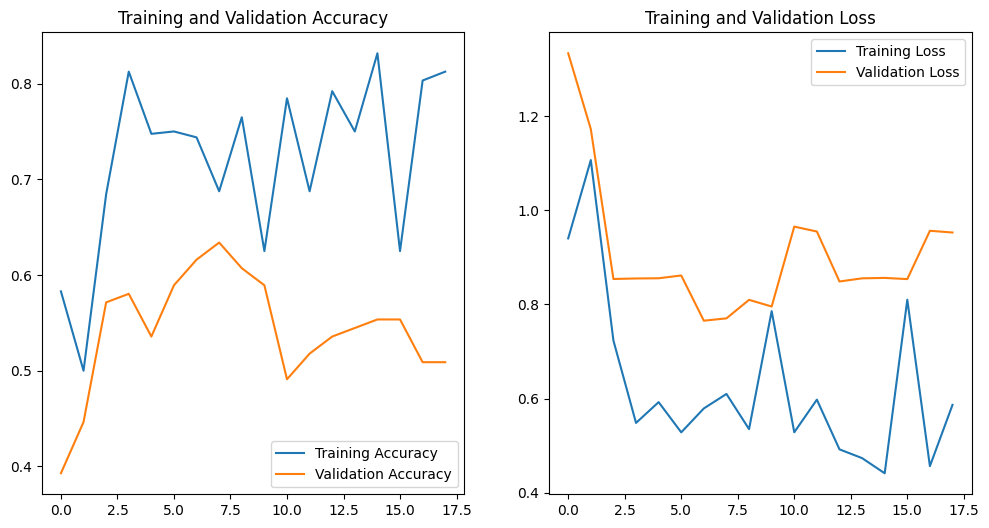

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
# ===================================================================
# EVALUASI MODEL PADA DATA TEST
# ===================================================================

print("🔍 Evaluasi Model pada Data Test...")

# Load model terbaik
best_model = tf.keras.models.load_model('best_model_densenet_roi_masking.keras')

# Reset generator untuk memastikan dimulai dari awal
test_generator.reset()

# Prediksi pada data test
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = best_model.predict(test_generator, steps=test_steps, verbose=1)

# Dapatkan kelas prediksi dan kelas sebenarnya
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Pastikan jumlah prediksi sesuai dengan jumlah data test
predicted_classes = predicted_classes[:len(true_classes)]

print(f"\n✅ Evaluasi selesai!")
print(f"Total sampel test: {test_generator.samples}")
print(f"Total prediksi: {len(predicted_classes)}")
print(f"Total true labels: {len(true_classes)}")

🔍 Evaluasi Model pada Data Test...
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 

✅ Evaluasi selesai!
Total sampel test: 93
Total prediksi: 93
Total true labels: 93

✅ Evaluasi selesai!
Total sampel test: 93
Total prediksi: 93
Total true labels: 93


In [10]:
# ===================================================================
# PERHITUNGAN METRIK EVALUASI
# ===================================================================

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Hitung metrik untuk setiap kelas
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average=None)
recall = recall_score(true_classes, predicted_classes, average=None)
f1 = f1_score(true_classes, predicted_classes, average=None)

# Hitung metrik rata-rata
precision_avg = precision_score(true_classes, predicted_classes, average='weighted')
recall_avg = recall_score(true_classes, predicted_classes, average='weighted')
f1_avg = f1_score(true_classes, predicted_classes, average='weighted')

# Tampilkan hasil
print("=" * 70)
print("HASIL EVALUASI MODEL PADA DATA TEST (CLAHE + ROI Masking)")
print("=" * 70)
print(f"\n📊 Overall Metrics:")
print(f"  Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision : {precision_avg:.4f}")
print(f"  Recall    : {recall_avg:.4f}")
print(f"  F1-Score  : {f1_avg:.4f}")

print(f"\n📊 Per-Class Metrics:")
for i, class_name in enumerate(class_names):
    print(f"\n  {class_name.upper()}:")
    print(f"    Precision : {precision[i]:.4f}")
    print(f"    Recall    : {recall[i]:.4f}")
    print(f"    F1-Score  : {f1[i]:.4f}")

print("\n" + "=" * 70)

HASIL EVALUASI MODEL PADA DATA TEST (CLAHE + ROI Masking)

📊 Overall Metrics:
  Accuracy  : 0.7634 (76.34%)
  Precision : 0.7935
  Recall    : 0.7634
  F1-Score  : 0.7489

📊 Per-Class Metrics:

  BENIGN:
    Precision : 0.7037
    Recall    : 0.8636
    F1-Score  : 0.7755

  MALIGNANT:
    Precision : 0.8286
    Recall    : 0.8056
    F1-Score  : 0.8169

  NORMAL:
    Precision : 1.0000
    Recall    : 0.3077
    F1-Score  : 0.4706



In [11]:
# ===================================================================
# CLASSIFICATION REPORT
# ===================================================================

print("📋 Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_names, digits=4)
print(report)

# Simpan report sebagai dictionary untuk visualisasi nanti
from sklearn.metrics import classification_report
report_dict = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)

📋 Classification Report:

              precision    recall  f1-score   support

      benign     0.7037    0.8636    0.7755        44
   malignant     0.8286    0.8056    0.8169        36
      normal     1.0000    0.3077    0.4706        13

    accuracy                         0.7634        93
   macro avg     0.8441    0.6590    0.6877        93
weighted avg     0.7935    0.7634    0.7489        93



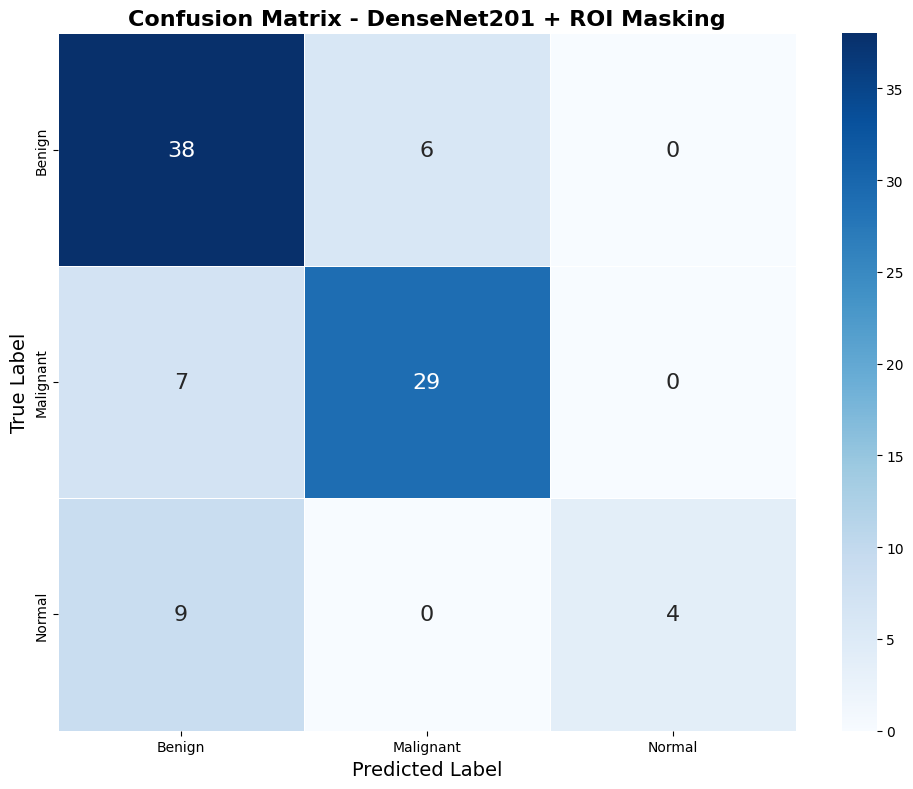

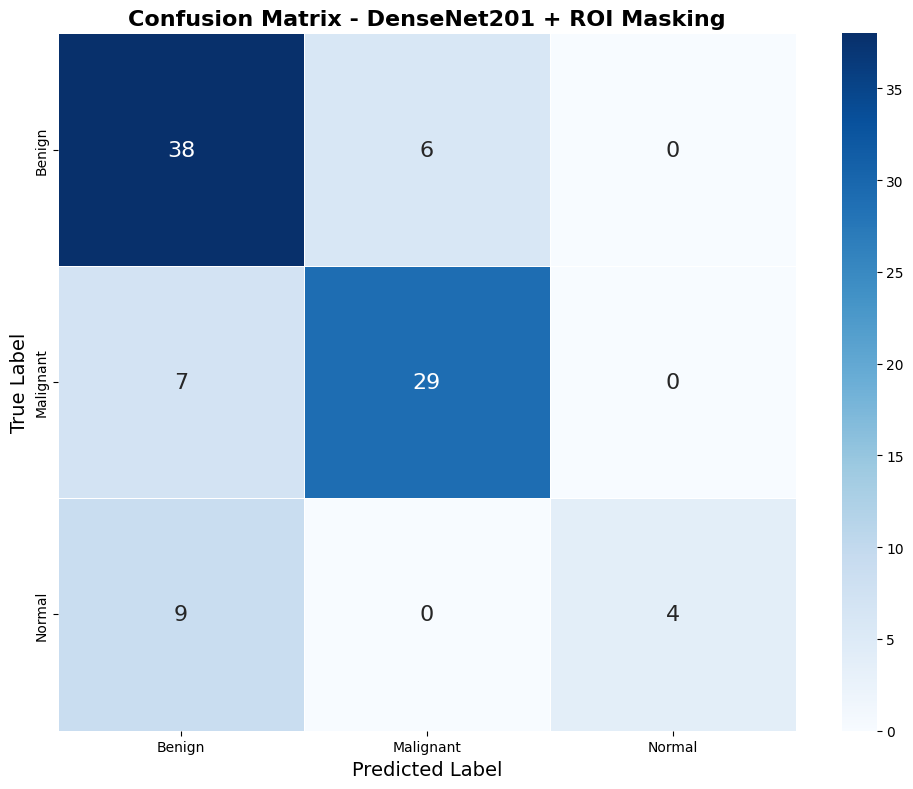

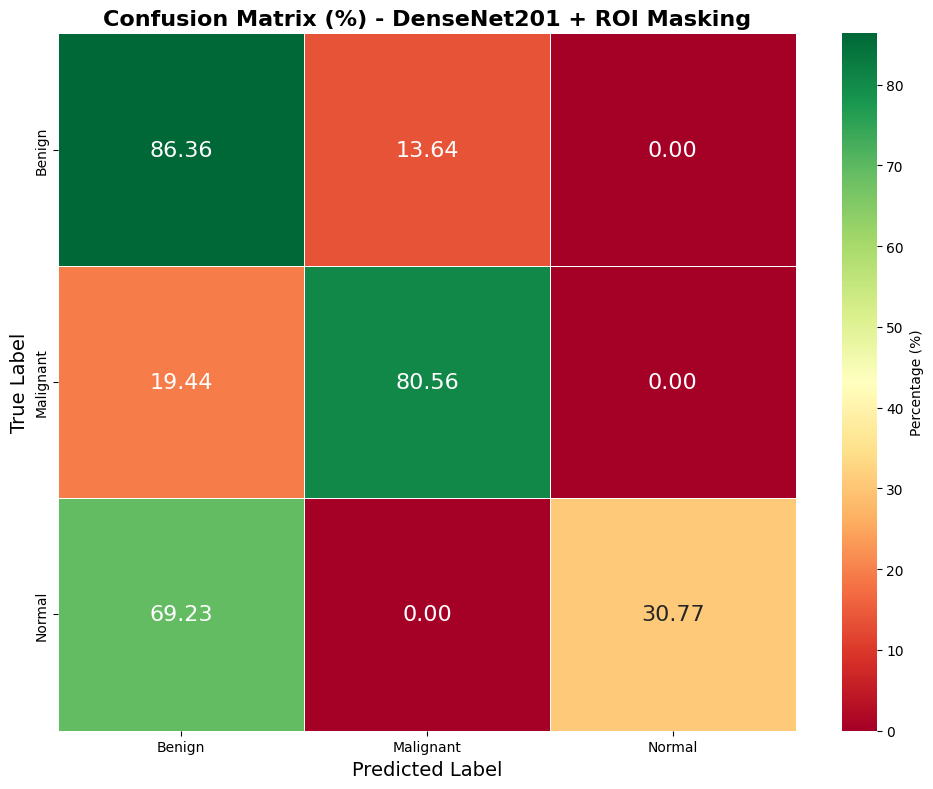

In [12]:
# ===================================================================
# CONFUSION MATRIX VISUALIZATION
# ===================================================================

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[c.capitalize() for c in class_names], 
            yticklabels=[c.capitalize() for c in class_names],
            linewidths=0.5, annot_kws={"size": 16})

plt.title('Confusion Matrix - DenseNet201 + ROI Masking', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# Tampilkan confusion matrix dalam bentuk persentase
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='RdYlGn', 
            xticklabels=[c.capitalize() for c in class_names], 
            yticklabels=[c.capitalize() for c in class_names],
            linewidths=0.5, annot_kws={"size": 16}, cbar_kws={'label': 'Percentage (%)'})

plt.title('Confusion Matrix (%) - DenseNet201 + ROI Masking', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

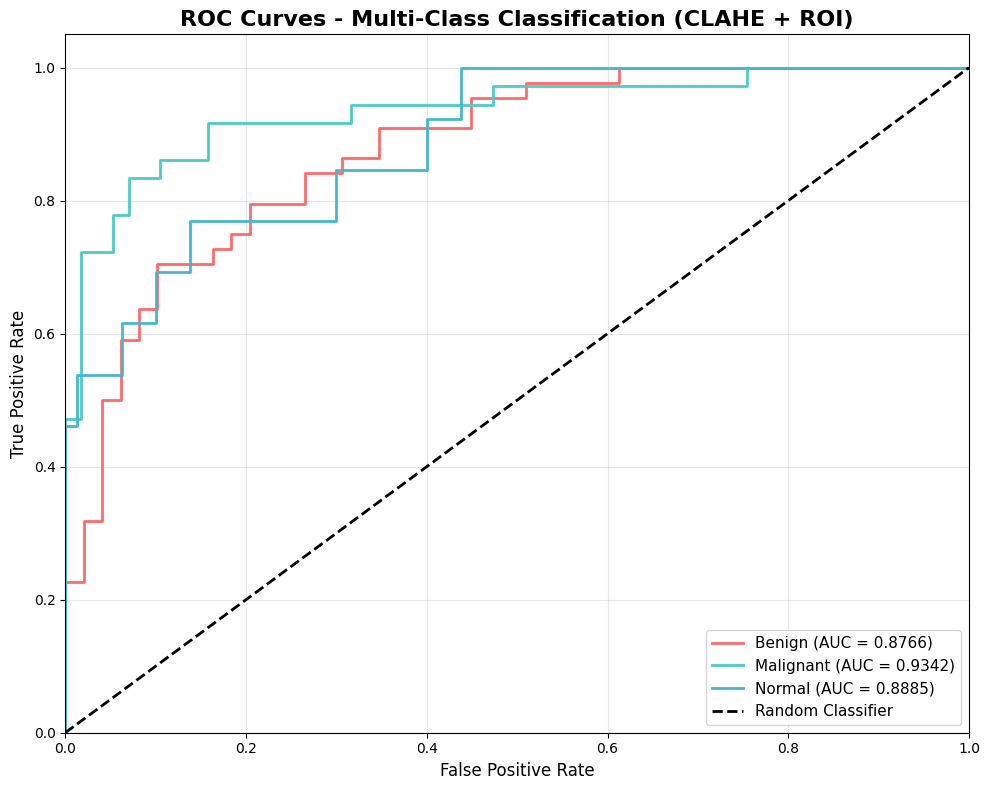

📊 AUC Scores:
  Benign: 0.8766
  Malignant: 0.9342
  Normal: 0.8885


In [13]:
# ===================================================================
# ROC CURVE & AUC SCORE (Multi-Class)
# ===================================================================

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize labels untuk ROC multi-class
y_test_binarized = label_binarize(true_classes, classes=range(NUM_CLASSES))
y_score = predictions[:test_generator.samples]

# Compute ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['#FF6B6B', '#4ECDC4', '#45B7D1'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i].capitalize()} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-Class Classification (CLAHE + ROI)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name.capitalize()}: {roc_auc[i]:.4f}")

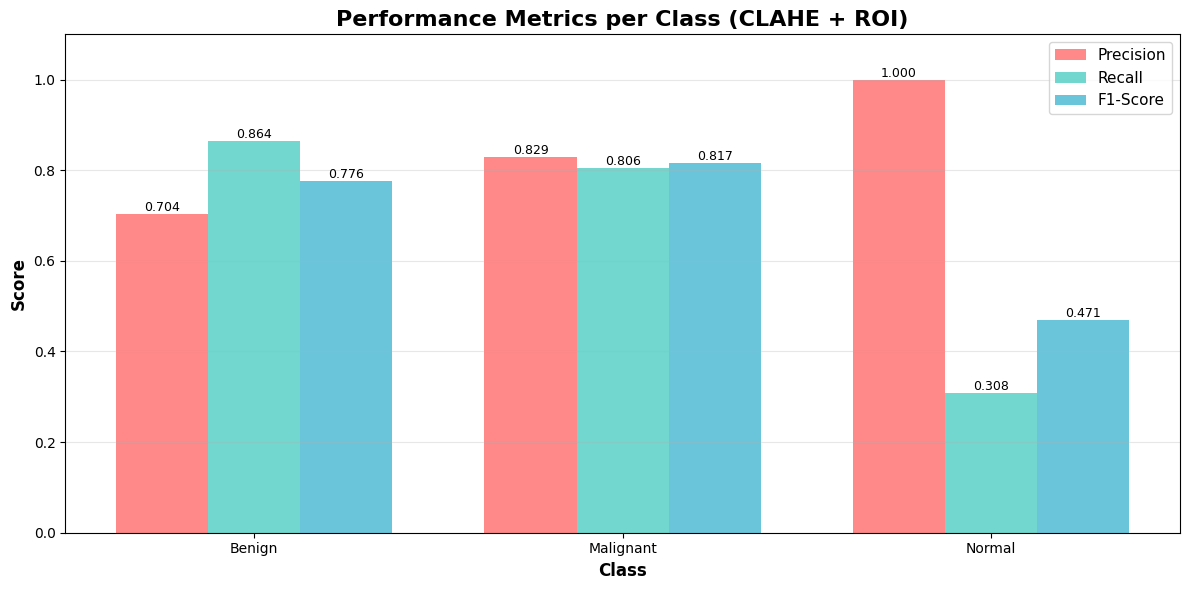

In [14]:
# ===================================================================
# METRIK PER-CLASS VISUALIZATION (Bar Charts)
# ===================================================================

# Prepare data
metrics_data = {
    'Class': [c.capitalize() for c in class_names],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

import pandas as pd
df_metrics = pd.DataFrame(metrics_data)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', color='#4ECDC4', alpha=0.8)
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#45B7D1', alpha=0.8)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics per Class (CLAHE + ROI)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([c.capitalize() for c in class_names])
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [15]:
# ===================================================================
# SUMMARY TABLE - COMPREHENSIVE RESULTS
# ===================================================================

import pandas as pd

# Create comprehensive summary table
summary_data = []
for i, class_name in enumerate(class_names):
    summary_data.append({
        'Class': class_name.capitalize(),
        'Precision': f"{precision[i]:.4f}",
        'Recall': f"{recall[i]:.4f}",
        'F1-Score': f"{f1[i]:.4f}",
        'Support': int(cm[i].sum())
    })

# Add overall metrics
summary_data.append({
    'Class': 'OVERALL (Weighted)',
    'Precision': f"{precision_avg:.4f}",
    'Recall': f"{recall_avg:.4f}",
    'F1-Score': f"{f1_avg:.4f}",
    'Support': int(cm.sum())
})

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("📊 COMPREHENSIVE EVALUATION SUMMARY (CLAHE + ROI Masking)")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Display as styled table
from IPython.display import display
styled_df = df_summary.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12pt',
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4ECDC4'), ('color', 'white'), 
                                  ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tr:last-child', 'props': [('background-color', '#FFE66D'), ('font-weight', 'bold')]}
])

display(styled_df)


📊 COMPREHENSIVE EVALUATION SUMMARY (CLAHE + ROI Masking)
             Class Precision Recall F1-Score  Support
            Benign    0.7037 0.8636   0.7755       44
         Malignant    0.8286 0.8056   0.8169       36
            Normal    1.0000 0.3077   0.4706       13
OVERALL (Weighted)    0.7935 0.7634   0.7489       93



📊 COMPREHENSIVE EVALUATION SUMMARY (CLAHE + ROI Masking)
             Class Precision Recall F1-Score  Support
            Benign    0.7037 0.8636   0.7755       44
         Malignant    0.8286 0.8056   0.8169       36
            Normal    1.0000 0.3077   0.4706       13
OVERALL (Weighted)    0.7935 0.7634   0.7489       93


,Class,Precision,Recall,F1-Score,Support
0,Benign,0.7037,0.8636,0.7755,44
1,Malignant,0.8286,0.8056,0.8169,36
2,Normal,1.0000,0.3077,0.4706,13
3,OVERALL (Weighted),0.7935,0.7634,0.7489,93


In [16]:
# ===================================================================
# TRAINING HISTORY ANALYSIS
# ===================================================================

# Create detailed training history table
history_df = pd.DataFrame({
    'Epoch': range(1, len(history.history['accuracy']) + 1),
    'Train Accuracy': [f"{acc:.4f}" for acc in history.history['accuracy']],
    'Val Accuracy': [f"{acc:.4f}" for acc in history.history['val_accuracy']],
    'Train Loss': [f"{loss:.4f}" for loss in history.history['loss']],
    'Val Loss': [f"{loss:.4f}" for loss in history.history['val_loss']]
})

print("\n📈 TRAINING HISTORY (First and Last 5 Epochs):")
print("="*80)
print("First 5 Epochs:")
print(history_df.head().to_string(index=False))
print("\nLast 5 Epochs:")
print(history_df.tail().to_string(index=False))
print("="*80)

# Find best epoch
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = np.max(history.history['val_accuracy'])

print(f"\n🏆 Best Epoch: {best_epoch}")
print(f"   Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")


📈 TRAINING HISTORY (First and Last 5 Epochs):
First 5 Epochs:
 Epoch Train Accuracy Val Accuracy Train Loss Val Loss
     1         0.5829       0.3929     0.9405   1.3341
     2         0.5000       0.4464     1.1071   1.1728
     3         0.6844       0.5714     0.7234   0.8542
     4         0.8125       0.5804     0.5482   0.8553
     5         0.7475       0.5357     0.5924   0.8558

Last 5 Epochs:
 Epoch Train Accuracy Val Accuracy Train Loss Val Loss
    14         0.7500       0.5446     0.4734   0.8556
    15         0.8317       0.5536     0.4412   0.8565
    16         0.6250       0.5536     0.8101   0.8540
    17         0.8032       0.5089     0.4563   0.9567
    18         0.8125       0.5089     0.5866   0.9530

🏆 Best Epoch: 8
   Best Validation Accuracy: 0.6339 (63.39%)


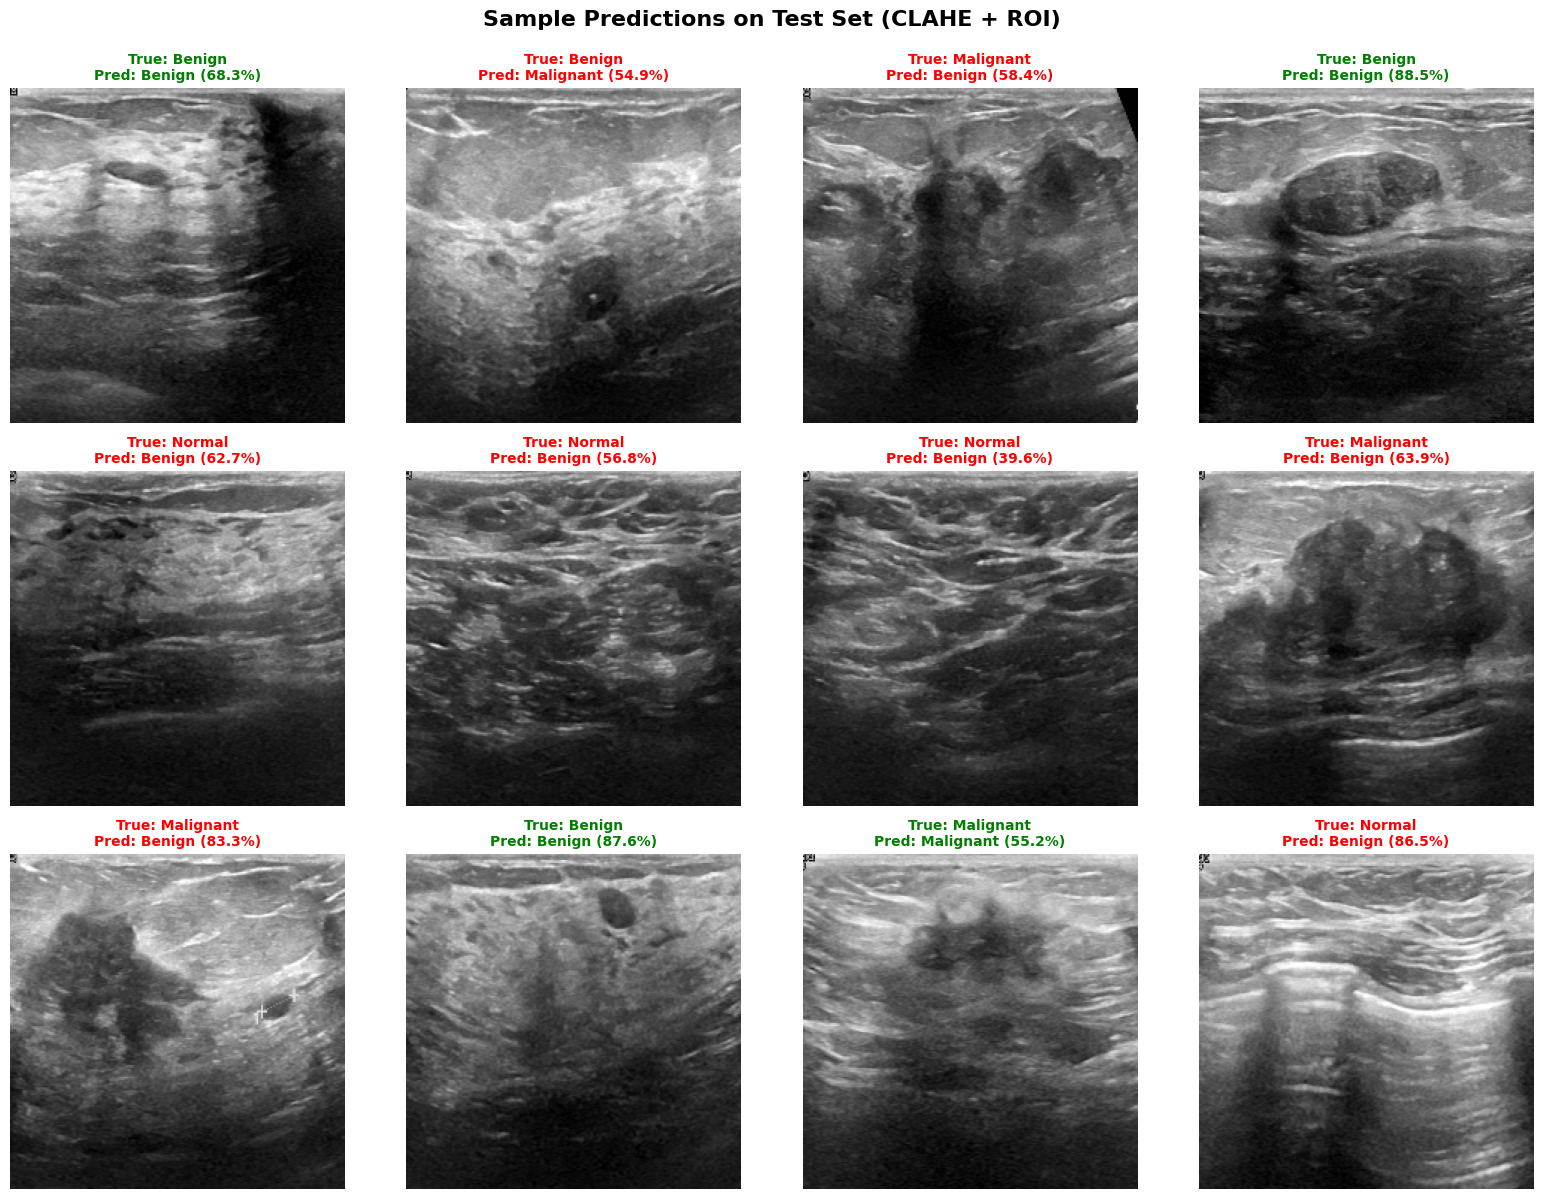

In [17]:
# ===================================================================
# SAMPLE PREDICTIONS VISUALIZATION
# ===================================================================

import random

# Get random samples from test set
num_samples = 12
test_files = []
test_labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(TEST_DIR, class_name)
    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for file in files[:4]:  # 4 samples per class
        test_files.append(file)
        test_labels.append(class_idx)

# Shuffle
combined = list(zip(test_files, test_labels))
random.shuffle(combined)
test_files, test_labels = zip(*combined)
test_files = list(test_files[:num_samples])
test_labels = list(test_labels[:num_samples])

# Create predictions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, (img_path, true_label) in enumerate(zip(test_files, test_labels)):
    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Apply preprocessing (CLAHE + ROI Masking)
    # For visualization, we apply without mask lookup (simplified)
    img_processed = apply_clahe_and_roi_masking(img_resized, mask_path=None)
    img_array = np.expand_dims(img_processed, axis=0)
    
    # Predict
    pred = best_model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred[0])
    confidence = pred[0][pred_class]
    
    # Display
    axes[idx].imshow(img_resized)
    
    # Color: green if correct, red if wrong
    color = 'green' if pred_class == true_label else 'red'
    title = f"True: {class_names[true_label].capitalize()}\n"
    title += f"Pred: {class_names[pred_class].capitalize()} ({confidence*100:.1f}%)"
    
    axes[idx].set_title(title, color=color, fontweight='bold', fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Sample Predictions on Test Set (CLAHE + ROI)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [18]:
# ===================================================================
# FINAL SUMMARY REPORT
# ===================================================================

print("\n" + "="*80)
print("🎯 FINAL EVALUATION REPORT - DenseNet201 + ROI Masking Breast Cancer Classification")
print("="*80)

print("\n📁 Dataset Information:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {validation_generator.samples}")
print(f"   Test samples: {test_generator.samples}")
print(f"   Classes: {', '.join([c.capitalize() for c in class_names])}")

print("\n🏗️ Model Architecture:")
print(f"   Backbone: DenseNet201 (Pre-trained on ImageNet)")
print(f"   Custom Head: Fast Learning Network (FLN)")
print(f"   Hidden Neurons: {NEURONS_FLN}")
print(f"   Dropout Rate: {DROPOUT_RATE}")

print("\n⚙️ Training Configuration:")
print(f"   Optimizer: Adam")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Epochs Trained: {len(history.history['accuracy'])}")
print(f"   Best Epoch: {best_epoch}")

print("\n🔬 Preprocessing:")
print(f"   CLAHE: ✓ (Contrast Limited Adaptive Histogram Equalization)")
print(f"   ROI Masking: ✓ (Region of Interest Extraction)")
print(f"   Data Augmentation: ✓ (Rotation, Shift, Zoom, Flip)")

print("\n📊 Test Set Performance:")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision (Weighted): {precision_avg:.4f}")
print(f"   Recall (Weighted): {recall_avg:.4f}")
print(f"   F1-Score (Weighted): {f1_avg:.4f}")

print("\n📈 Per-Class F1-Scores:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name.capitalize()}: {f1[i]:.4f}")

print("\n🎯 AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name.capitalize()}: {roc_auc[i]:.4f}")

print("\n" + "="*80)
print("✅ Evaluation Complete!")
print("="*80)


🎯 FINAL EVALUATION REPORT - DenseNet201 + ROI Masking Breast Cancer Classification

📁 Dataset Information:
   Training samples: 824
   Validation samples: 113
   Test samples: 93
   Classes: Benign, Malignant, Normal

🏗️ Model Architecture:
   Backbone: DenseNet201 (Pre-trained on ImageNet)
   Custom Head: Fast Learning Network (FLN)
   Hidden Neurons: 471
   Dropout Rate: 0.44

⚙️ Training Configuration:
   Optimizer: Adam
   Learning Rate: 0.000506
   Batch Size: 16
   Epochs Trained: 18
   Best Epoch: 8

🔬 Preprocessing:
   CLAHE: ✓ (Contrast Limited Adaptive Histogram Equalization)
   ROI Masking: ✓ (Region of Interest Extraction)
   Data Augmentation: ✓ (Rotation, Shift, Zoom, Flip)

📊 Test Set Performance:
   Accuracy: 0.7634 (76.34%)
   Precision (Weighted): 0.7935
   Recall (Weighted): 0.7634
   F1-Score (Weighted): 0.7489

📈 Per-Class F1-Scores:
   Benign: 0.7755
   Malignant: 0.8169
   Normal: 0.4706

🎯 AUC Scores:
   Benign: 0.8766
   Malignant: 0.9342
   Normal: 0.8885

✅ 

In [19]:
# ===================================================================
# VISUALISASI CONTOH PREPROCESSING (CLAHE + ROI Masking)
# ===================================================================

def visualize_preprocessing_with_mask(img_path, class_name, split='test'):
    """
    Visualisasi proses preprocessing: Original -> CLAHE -> ROI Masked
    """
    # Load original image
    img_original = cv2.imread(img_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_original = cv2.resize(img_original, (IMG_WIDTH, IMG_HEIGHT))
    
    # Get filename
    filename = os.path.basename(img_path)
    
    # Find corresponding mask
    mask_path = find_mask_path(filename, class_name, split)
    
    # Apply CLAHE only
    img_clahe = apply_clahe_and_roi_masking(img_original.copy(), mask_path=None)
    
    # Apply CLAHE + ROI Masking
    img_masked = apply_clahe_and_roi_masking(img_original.copy(), mask_path=mask_path)
    
    # Visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original
    axes[0].imshow(img_original)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Mask (if exists)
    if mask_path and os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('ROI Mask', fontsize=12, fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, 'No Mask Available', ha='center', va='center', fontsize=12)
        axes[1].set_title('ROI Mask', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # CLAHE only (need to denormalize for visualization)
    # Since preprocess_input changes range, we show original with CLAHE
    img_clahe_viz = img_original.copy().astype('uint8')
    lab = cv2.cvtColor(img_clahe_viz, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    img_clahe_viz = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    axes[2].imshow(img_clahe_viz)
    axes[2].set_title('After CLAHE', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    # CLAHE + ROI (visualize the masked region)
    if mask_path and os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask_3ch = cv2.merge([mask_binary, mask_binary, mask_binary])
        img_roi_viz = cv2.bitwise_and(img_clahe_viz, mask_3ch)
        axes[3].imshow(img_roi_viz)
        axes[3].set_title('After CLAHE + ROI Masking', fontsize=12, fontweight='bold')
    else:
        axes[3].imshow(img_clahe_viz)
        axes[3].set_title('After CLAHE (No Mask)', fontsize=12, fontweight='bold')
    axes[3].axis('off')
    
    plt.suptitle(f'Preprocessing Pipeline: {filename}\nClass: {class_name.capitalize()}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example usage - uncomment and provide actual image path
# visualize_preprocessing_with_mask(
#     "D:\\Kuliah\\Semester 5\\HUMIC\\dataset gabungan\\test\\benign\\benign (201).png",
#     "benign",
#     "test"
# )

print("\n✅ Visualization function ready!")
print("   Use: visualize_preprocessing_with_mask(img_path, class_name, split)")
print("   Example: visualize_preprocessing_with_mask('path/to/image.png', 'benign', 'test')")


✅ Visualization function ready!
   Use: visualize_preprocessing_with_mask(img_path, class_name, split)
   Example: visualize_preprocessing_with_mask('path/to/image.png', 'benign', 'test')
